# ToDo

- Create environment variable for data.

#### We need a handful of plots to start defining the pilot sample: ####
- ra vs dec for full redmapper catalog and trimmed catalog
- richness vs redshift for trimmed catalog for spectroscopic clusters only
- think of other plots to make that will help us define a "pilot" sample (e.g., using imag, size, redshift, richness, etc.)
- look at decam_galdepth[2] and/or decam_nobs[2] to find clusters with deeper-than average depth or coverage

### What do we have ###

* SDSS/DR8 redmapper cluster catalog (N~400,000 central galaxies) -- redmapper_isedfit_v5.10_centrals.fits
* redmapper catalog matched to DECaLS/DR3 (N~250,000 matches) -- tractor-redmapper_isedfit_v5.10_centrals.fits

### Convenient References
* [DECaLS Documentation](http://legacysurvey.org/)
* [GitHub Repository](https://github.com/moustakas/siena-astrophysics)
* [Markdown Quick Reference Guide](https://en.support.wordpress.com/markdown-quick-reference)
* [FITS Documentation](http://docs.astropy.org/en/stable/io/fits/#)

In [1]:
import os
import warnings

from astropy.io import fits
import numpy as np
import mpl_toolkits
import matplotlib.pyplot as plt

import fitsio
from desitarget.targetmask import desi_mask, bgs_mask
from desiutil.plots import init_sky, plot_healpix_map, plot_grid_map, plot_sky_circles, plot_sky_binned, prepare_data

%matplotlib inline

### Define the operations to be performed in the subsequent cells.

In [2]:
# Trims data; outputs trimmed data into a fits file
CUTS = False
QAPLOTS = True

### Specify the path and the file.

In [16]:
path = '/Users/kevinnapier/research/dmhalos/'
# file = 'tractor-redmapper_isedfit_v5.10_centrals.fits' # dr3data; which one should I use?
centrals = 'redmapper_isedfit_v5.10_centrals.fits' 

In [11]:
data = fits.getdata(os.path.join(path, centrals))
centralsdata = fits.getdata(os.path.join(path, centrals))

In [12]:
if CUTS == True:
    cuts = np.where(data['OBJID'] == -1)
    newdata = np.delete(data, cuts[0])
    fits.writeto(os.path.join(path,'tractor_matched_centrals.fits'), newdata, overwrite=True)

In [13]:
matched = fitsio.read(os.path.join(path, 'tractor_matched_centrals.fits'))
ii=fitsio.FITS(os.path.join(path, centrals))
#print(ii[1])

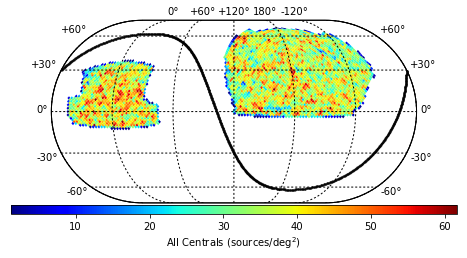

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.figure(figsize=(8,4))
    basemap = init_sky(galactic_plane_color='k');
    plot_sky_binned(centralsdata['RA'], centralsdata['DEC'], verbose=False, clip_lo='!1', plot_type='healpix', 
                    cmap='jet', label=r'All Centrals (sources/deg$^2$)', basemap=basemap);

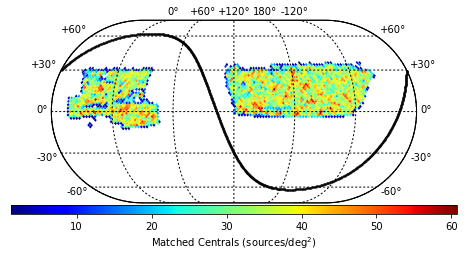

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.figure(figsize=(8,4))
    basemap = init_sky(galactic_plane_color='k');
    plot_sky_binned(matched['RA'], matched['DEC'], verbose=False, clip_lo='!1', plot_type='healpix', cmap='jet', 
                label=r'Matched Centrals (sources/deg$^2$)', basemap=basemap);

In [ ]:
#plt.plot(centralsdata['RA'], centralsdata['DEC'],'bo')

In [10]:
#plt.plot(matched['RA'], matched['DEC'],'ro')